# 1.1 Classification of sectors with gradient descent algorithm


## Definition of the sectors

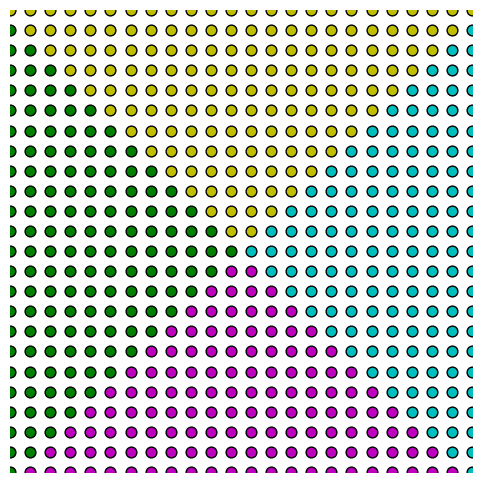

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 24

# Coordinates
V = np.linspace(-2, 2, N) #Return evenly spaced 24 numbers over interval <-2,2>.
X, Y = np.meshgrid(V, V)  #Return a tuple of coordinate matrices from coordinate vectors.
Coordinates = np.vstack((X.ravel(), Y.ravel()))  #ravel - return a contiguous flattened array, vstack stacks arrays vertically

# Regions
Regions = 1 * (Y >= X) + 2 * ((Y > -X) | (np.abs(X + Y) < 1e-2)) + 1  #assigns 1,2,3,4 to regions based on Y,X values
Regions = Regions.ravel()

# Figure
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
Colors = ['m', 'g', 'c', 'y']

# Plot
for r in range(1, 5):
    I = np.where(Regions == r)
    plt.scatter(Coordinates[0, I], Coordinates[1, I], c=Colors[r-1], edgecolor='k', s=60)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## TRaining Gradient Descent

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

Coordinates = torch.tensor(Coordinates.T, dtype=torch.float32)  #making tensor from coordinates array
Regions = torch.tensor(Regions, dtype=torch.long)

# Probabilities (one-hot encoding for 4 classes)
Probabilities = torch.zeros(4, len(Regions), dtype=torch.float32)  #create tensor filled with 0;s with size of 4 x len(reigons)
for n in range(len(Regions)):
    Probabilities[Regions[n]-1, n] = 1  

# MLP
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultiLayerPerceptron, self).__init__()
        # Define layers
        self.l1 = nn.Linear(input_size, hidden_sizes[0])
        self.l2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.out = nn.Linear(hidden_sizes[1], output_size)
        self.act = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through the network
        x = self.l1(x)
        x = self.l2(x)
        x = self.out(x)
        return self.act(x)

# Initialize 
mlp = MultiLayerPerceptron(input_size=2, hidden_sizes=[4, 4], output_size=4)


# Loss function and optimizer
optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()


# Options
epochs = 50
min_mse = 1e-8
batch_size = 10
num_batches = len(Coordinates) // batch_size

# Training 
for epoch in range(epochs):
    for i in range(num_batches):
        # Batch sampling
        start = i * batch_size
        end = start + batch_size
        inputs = Coordinates[start:end]
        targets = Probabilities[:, start:end].T 

        # Forward pass
        outputs = mlp(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    if loss.item() <= min_mse:
        break

print("Training complete")


Epoch [1/50], Loss: 0.2066
Epoch [2/50], Loss: 0.1870
Epoch [3/50], Loss: 0.1807
Epoch [4/50], Loss: 0.1823
Epoch [5/50], Loss: 0.1810
Epoch [6/50], Loss: 0.1676
Epoch [7/50], Loss: 0.1296
Epoch [8/50], Loss: 0.0576
Epoch [9/50], Loss: 0.0130
Epoch [10/50], Loss: 0.0037
Epoch [11/50], Loss: 0.0013
Epoch [12/50], Loss: 0.0005
Epoch [13/50], Loss: 0.0002
Epoch [14/50], Loss: 0.0001
Epoch [15/50], Loss: 0.0000
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0000
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [21/50], Loss: 0.0000
Epoch [22/50], Loss: 0.0000
Epoch [23/50], Loss: 0.0000
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Training complete


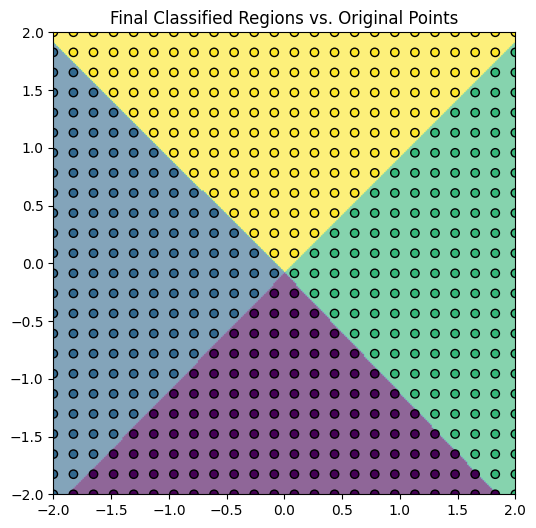

In [30]:

# Coordinates of the points
N2 = 300
V = np.linspace(-2, 2, N2)
X, Y = np.meshgrid(V, V)
Coordinates2 = np.vstack((X.ravel(), Y.ravel())).T  # shape [N2*N2, 2]
Coordinates2 = torch.tensor(Coordinates2, dtype=torch.float32)

# Forward propagate to get output probabilities
with torch.no_grad(): 
    Probabilities2 = mlp(Coordinates2)
    _, Regions2 = torch.max(Probabilities2, dim=1)  # Get most probable regions

Regions2 = Regions2.numpy().reshape(N2, N2)

plt.figure(figsize=(6, 6))
plt.imshow(Regions2, extent=(-2, 2, -2, 2), origin='lower', alpha=0.6)
plt.scatter(Coordinates[:, 0], Coordinates[:, 1], c=Regions, edgecolor='k')
plt.title('Final Classified Regions vs. Original Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

I needed to put way lower MSE or just let model run all epochs, otherwise the region wasnt accurate.

# 1.2 Classification of spirals with Levenberg-Marquardt algorithm


## LM


#### Initialization

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Parameters for spiral generation
R = 4  # Number of regions
k = 8  # Spiral factor
N = R  # Number of spiral arms
S = k * N
x0, y0 = 0, 0

# Initialization
X = np.zeros((N, S))
Y = np.zeros((N, S))
Regions = np.zeros((N, S))

# Generate spiral coordinates and regions
for s in range(S):
    r = np.floor(s * R / S).astype(int) + 1  # Assign region
    for n in range(N):
        a0 = n / N * 2 * np.pi / k  
        a = a0 + s * 2 * np.pi / S  
        b = a0  # Radius factor (spiral scaling)
        X[n, s] = b * np.cos(a) + x0
        Y[n, s] = b * np.sin(a) + y0
        Regions[n, s] = r

Coordinates = np.vstack((X.ravel(), Y.ravel()))  # (2, S*N)
Regions = Regions.ravel()  # (S*N, )


onehot_encoder = OneHotEncoder(sparse=False)
Probabilities = onehot_encoder.fit_transform(Regions.reshape(-1, 1))

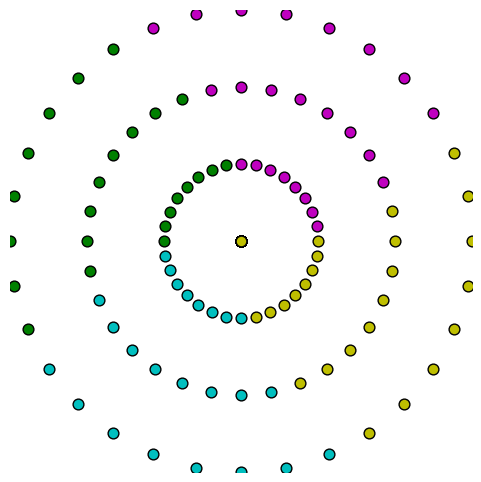

In [32]:
# Figure
plt.figure(figsize=(6, 6))
plt.axis('off')
Colors = ['m', 'g', 'c', 'y']

# Plot points for each region
for r in range(1, R + 1):
    I = np.where(Regions == r)[0]
    plt.scatter(Coordinates[0, I], Coordinates[1, I], c=Colors[r - 1], edgecolor='k', s=60)

plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#### LM Algorithm 

Training completed with Levenberg-Marquardt algorithm.
Accuracy of the model: 0.81


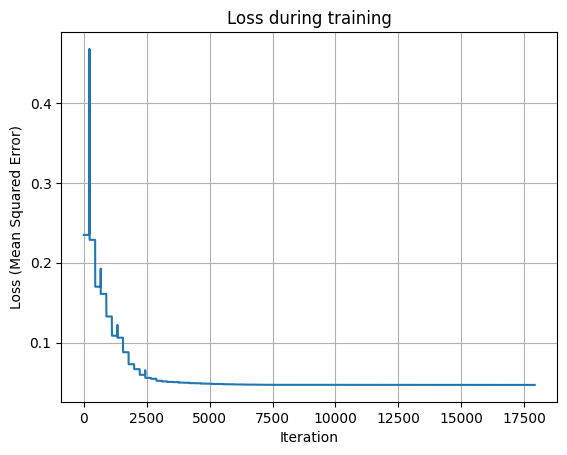

In [33]:
import numpy as np
from scipy.optimize import least_squares

def softmax(z):
    e_z = np.exp(z - np.max(z)) 
    return e_z / e_z.sum(axis=0, keepdims=True)



def mlp(weights, X, hidden_sizes):
    input_size = X.shape[0]  # Number of input features
    idx = 0
    activations = [X]

    for layer_size in hidden_sizes[:-1]:  # All layers except the last (diff activation)
        W = weights[idx:idx + input_size * layer_size].reshape(input_size, layer_size)
        idx += input_size * layer_size
        b = weights[idx:idx + layer_size].reshape(1, layer_size)
        idx += layer_size

        # Apply activation (tanh) to the current layer
        X = np.tanh(np.dot(W.T, X) + b.T)  # W.T * X + b.T cause X and W need to match in dimensions
        activations.append(X)

        input_size = layer_size

    # Last layer: output with softmax activation
    W = weights[idx:idx + input_size * hidden_sizes[-1]].reshape(input_size, hidden_sizes[-1])
    idx += input_size * hidden_sizes[-1]
    b = weights[idx:idx + hidden_sizes[-1]].reshape(1, hidden_sizes[-1])
    output_layer = np.dot(W.T, X) + b.T
    
    # Apply softmax to the output layer to make it into probabilities that sum up to 1
    final_output = softmax(output_layer)
    return final_output  



def error_function(weights, X, y, hidden_sizes):
    predictions = mlp(weights, X, hidden_sizes)  # shape: (R, N*S)
    predictions = predictions.T  

    residuals = predictions - y
    return residuals.ravel()  #flatten for least_squares

def error_function_with_history(weights, X, y, hidden_sizes):
    predictions = mlp(weights, X, hidden_sizes)  # shape: (R, N*S)
    predictions = predictions.T  

    residuals = predictions - y
    loss = np.mean(np.square(residuals))  # Mean Squared Error
    loss_history.append(loss)  # Append the loss to history

    return residuals.ravel()


loss_history = []
input_size = Coordinates.shape[0]  #2 input, x,y
hidden_sizes = [16, 8, R]  # Layers: 16 neurons, 8 neurons, output with R neurons
n_weights = (input_size * hidden_sizes[0] + hidden_sizes[0]) + \
            (hidden_sizes[0] * hidden_sizes[1] + hidden_sizes[1]) + \
            (hidden_sizes[1] * hidden_sizes[2] + hidden_sizes[2])
initial_weights = np.random.randn(n_weights)  # random weights at start

result = least_squares(error_function_with_history, initial_weights, args=(Coordinates, Probabilities, hidden_sizes), method='lm')

optimized_weights = result.x

print("Training completed with Levenberg-Marquardt algorithm.")

predicted_regions = np.argmax(mlp(optimized_weights, Coordinates, hidden_sizes), axis=0) + 1  # Predictions for training data
accuracy = np.mean(predicted_regions == Regions)  
print(f"Accuracy of the model: {accuracy:.2f}")

# Plot the loss history
plt.plot(loss_history)
plt.title('Loss during training')
plt.xlabel('Iteration')
plt.ylabel('Loss (Mean Squared Error)')
plt.grid()
plt.show()

#### Final visualisation and prediction

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


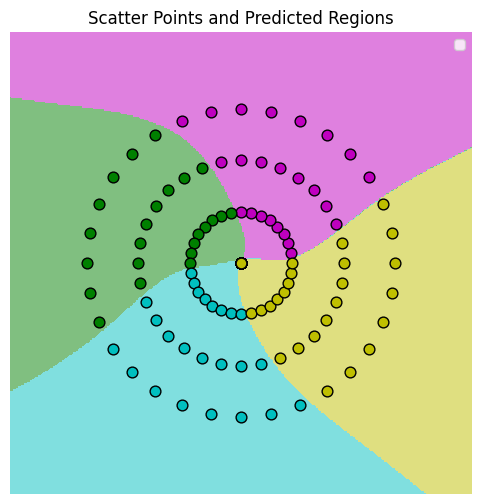

In [34]:

from matplotlib.colors import ListedColormap
M = (1 + 1 / N / 2) / k * 2 * np.pi
N2=300
X, Y = np.meshgrid(np.linspace(-M, +M, N2) + x0, np.linspace(-M, +M, N2) + y0)

Coordinates2 = np.vstack((X.ravel(), Y.ravel()))  # (2, N2*N2)
Probabilities2 = mlp(optimized_weights, Coordinates2, hidden_sizes)  
Regions2 = np.argmax(Probabilities2, axis=0) + 1  # Adding 1 because regions start from 1
Regions2_reshaped = Regions2.reshape(N2, N2)

Colors = ['m', 'g', 'c', 'y']
cmap = ListedColormap(Colors) #for regions, continous

plt.figure(figsize=(6, 6))
plt.imshow(Regions2_reshaped, extent=(np.min(X), np.max(X), np.min(Y), np.max(Y)), origin='lower', cmap=cmap, alpha=0.5)
plt.axis('off')

# Overlay scatter points with the same colors for the same class
for r in range(1, R + 1):
    I = np.where(Regions == r)[0]
    plt.scatter(Coordinates[0, I], Coordinates[1, I], c=Colors[r - 1], edgecolor='k', s=60)

plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Scatter Points and Predicted Regions')
plt.legend()
plt.show()


## Adam optimizer
#### I made it because i couldnt figure out how to make LM at first


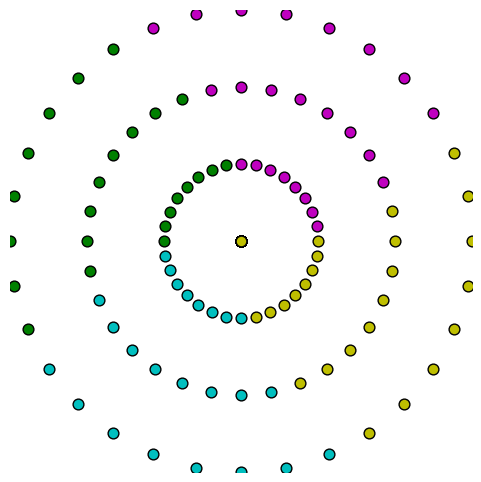

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
R = 4
k = 8
N = R
S = k * N

# Initialization
x0 = 0
y0 = 0
X = np.zeros((N, S))
Y = np.zeros((N, S))
Regions = np.zeros((N, S))

# Spirals coordinates and regions
for s in range(S):
    r = np.floor((s * R) / S).astype(int) +1
    for n in range(N):
        a0 = n / N * 2 * np.pi / k
        a = a0 + s * 2 * np.pi / S
        b = a0
        X[n, s] = b * np.cos(a) + x0
        Y[n, s] = b * np.sin(a) + y0
        Regions[n, s] = r 

# Reshape Coordinates and Regions
Coordinates = np.vstack((X.ravel(), Y.ravel()))
Regions = Regions.ravel()


# Figure
plt.figure(figsize=(6, 6))
plt.axis('off')
Colors = ['m', 'g', 'c', 'y']

# Plot points for each region
for r in range(1, R + 1):
    I = np.where(Regions == r)[0]
    plt.scatter(Coordinates[0, I], Coordinates[1, I], c=Colors[r - 1], edgecolor='k', s=60)

plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## Adam

Epoch 1/200


c:\Users\mary9\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3677 - mean_squared_error: 0.1845
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9392 - mean_squared_error: 0.1295 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7285 - mean_squared_error: 0.0942 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8236 - mean_squared_error: 0.1024 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7888 - mean_squared_error: 0.0957 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8742 - mean_squared_error: 0.0954 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0480 - mean_squared_error: 0.1205 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6907 - mean_squared_error: 0.0943 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7738 - mean_squared_error: 0.1029 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7478 - mean_squared_error: 0.0998 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7318 - mean_

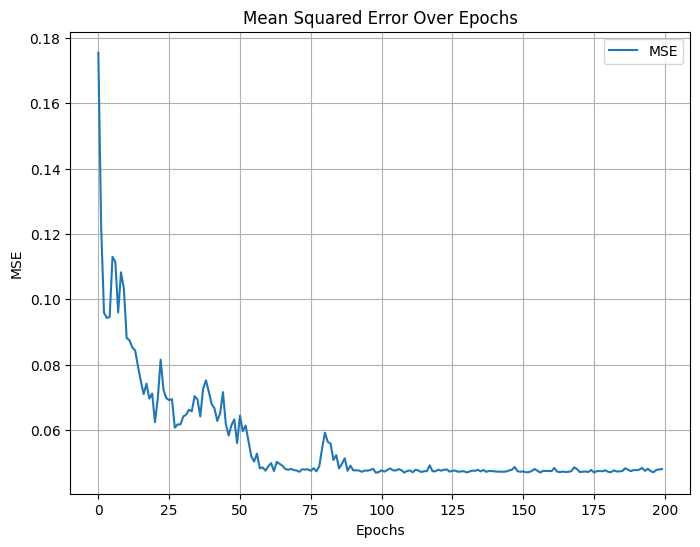

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

# Probabilities
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
Probabilities = onehot_encoder.fit_transform(Regions.reshape(-1, 1))

model=Sequential()

model.add(Dense(16, input_dim=2, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(R, activation='tanh'))
model.add(Dense(R, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['mean_squared_error'])

history = model.fit(Coordinates.T, Probabilities, epochs=200, batch_size=32)


# Plot MSE over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.title('Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


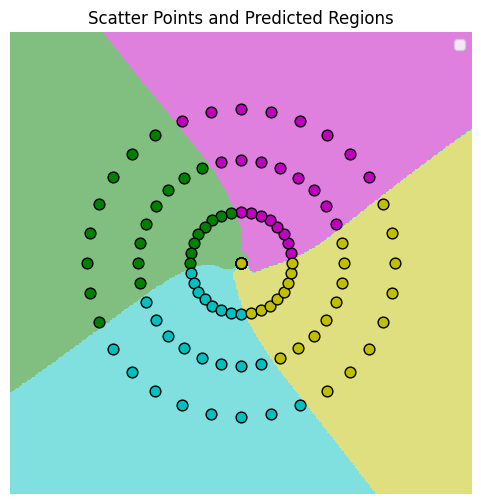

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Parameters
M = (1 + 1 / N / 2) / k * 2 * np.pi
N2 = 300
V = np.linspace(-M, +M, N2)

X, Y = np.meshgrid(V + x0, V + y0) #Creates grids of points for visualisation
Coordinates2 = np.vstack((X.ravel(), Y.ravel()))

Probabilities2 = model.predict(Coordinates2.T)  
 
Regions2 = np.argmax(Probabilities2, axis=1)+1  #choosing which probability is highest = region

Regions2_reshaped = Regions2.reshape(N2, N2)

Colors = ['m', 'g', 'c', 'y']
cmap = ListedColormap(Colors)

plt.figure(figsize=(6, 6))
plt.imshow(Regions2_reshaped, extent=(np.min(X), np.max(X), np.min(Y), np.max(Y)), origin='lower', cmap=cmap, alpha=0.5)
plt.axis('off')

# Overlay scatter points with the same colors for the same class
for r in range(1, R + 1):
    I = np.where(Regions == r)[0]
    plt.scatter(Coordinates[0, I], Coordinates[1, I], c=Colors[r - 1], edgecolor='k', s=60)

plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Scatter Points and Predicted Regions')
plt.legend()
plt.show()


# Plasticity paradigm 
- ability of Neural Network to quickly change its predictions in response to new information. Plasticity is high in the beginning, where each iteration(epoch) gives big improvements. Plasticity is lost over time, as we approach model's maximal accuracy.

- Neural Networks learn by adjusting weights of the connections - like synaptic connections in the brain based on new activity/experience

- Backpropagation - minimizing error between predicted and actual outputs, updating weights using chain rule.

- Plasticity of structure. Different number of layers, different activation functions etc.
